In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
customers = pd.read_csv('dataset/Customers.csv')
transactions = pd.read_csv('dataset/Transactions.csv')
products = pd.read_csv('dataset/Products.csv')

In [3]:
# Merge transactions with products to get product categories
merged_transactions = pd.merge(transactions, products, on="ProductID", how="left")

# Group by CustomerID to aggregate purchase data
transactions_agg = merged_transactions.groupby("CustomerID").agg({
    "Quantity": "sum",
    "TotalValue": "sum",
    "TransactionID": "count"
}).reset_index()

transactions_agg.rename(columns={
    "Quantity": "TotalQuantity",
    "TotalValue": "TotalSpend",
    "TransactionID": "NumTransactions"
}, inplace=True)

# most purchased category for each customer
most_purchased_category = merged_transactions.groupby(["CustomerID", "Category"])["Quantity"].sum().reset_index()
most_purchased_category = most_purchased_category.loc[
    most_purchased_category.groupby("CustomerID")["Quantity"].idxmax(),
    ["CustomerID", "Category"]
].rename(columns={"Category": "MostPurchasedCategory"})

customer_merged = pd.merge(customers, transactions_agg, on="CustomerID", how="left")

customer_merged = pd.merge(customer_merged, most_purchased_category, on="CustomerID", how="left")

customer_merged.fillna({"TotalQuantity": 0, "TotalSpend": 0, "NumTransactions": 0, "MostPurchasedCategory": "None"}, inplace=True)

In [4]:
customer_merged

,CustomerID,CustomerName,Region,SignupDate,TotalQuantity,TotalSpend,NumTransactions,MostPurchasedCategory
0,C0001,Lawrence Carroll,South America,2022-07-10,12.0,3354.52,5.0,Electronics
1,C0002,Elizabeth Lutz,Asia,2022-02-13,10.0,1862.74,4.0,Home Decor
2,C0003,Michael Rivera,South America,2024-03-07,14.0,2725.38,4.0,Home Decor
3,C0004,Kathleen Rodriguez,South America,2022-10-09,23.0,5354.88,8.0,Home Decor
4,C0005,Laura Weber,Asia,2022-08-15,7.0,2034.24,3.0,Electronics
...,...,...,...,...,...,...,...,...
195,C0196,Laura Watts,Europe,2022-06-07,12.0,4982.88,4.0,Home Decor
196,C0197,Christina Harvey,Europe,2023-03-21,9.0,1928.65,3.0,Electronics
197,C0198,Rebecca Ray,Europe,2022-02-27,3.0,931.83,2.0,Clothing
198,C0199,Andrea Jenkins,Europe,2022-12-03,9.0,1979.28,4.0,Home Decor


In [5]:
customer_merged["MostPurchasedCategory"].value_counts()

MostPurchasedCategory
Books          56
Home Decor     54
Clothing       46
Electronics    43
None            1
Name: count, dtype: int64

In [6]:
# drop None from MostPurchasedCategory
customer_merged = customer_merged[customer_merged["MostPurchasedCategory"] != "None"]

In [7]:
customer_merged

,CustomerID,CustomerName,Region,SignupDate,TotalQuantity,TotalSpend,NumTransactions,MostPurchasedCategory
0,C0001,Lawrence Carroll,South America,2022-07-10,12.0,3354.52,5.0,Electronics
1,C0002,Elizabeth Lutz,Asia,2022-02-13,10.0,1862.74,4.0,Home Decor
2,C0003,Michael Rivera,South America,2024-03-07,14.0,2725.38,4.0,Home Decor
3,C0004,Kathleen Rodriguez,South America,2022-10-09,23.0,5354.88,8.0,Home Decor
4,C0005,Laura Weber,Asia,2022-08-15,7.0,2034.24,3.0,Electronics
...,...,...,...,...,...,...,...,...
195,C0196,Laura Watts,Europe,2022-06-07,12.0,4982.88,4.0,Home Decor
196,C0197,Christina Harvey,Europe,2023-03-21,9.0,1928.65,3.0,Electronics
197,C0198,Rebecca Ray,Europe,2022-02-27,3.0,931.83,2.0,Clothing
198,C0199,Andrea Jenkins,Europe,2022-12-03,9.0,1979.28,4.0,Home Decor


In [ ]:
# convert categorical data to numerical
customer_merged["MostPurchasedCategory"] = customer_merged["MostPurchasedCategory"].astype("category")
customer_merged["MostPurchasedCategory"] = customer_merged["MostPurchasedCategory"].cat.codes
customer_merged

/tmp/ipykernel_59975/1739635240.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_merged["MostPurchasedCategory"] = customer_merged["MostPurchasedCategory"].astype("category")
/tmp/ipykernel_59975/1739635240.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_merged["MostPurchasedCategory"] = customer_merged["MostPurchasedCategory"].cat.codes


,CustomerID,CustomerName,Region,SignupDate,TotalQuantity,TotalSpend,NumTransactions,MostPurchasedCategory
0,C0001,Lawrence Carroll,South America,2022-07-10,12.0,3354.52,5.0,2
1,C0002,Elizabeth Lutz,Asia,2022-02-13,10.0,1862.74,4.0,3
2,C0003,Michael Rivera,South America,2024-03-07,14.0,2725.38,4.0,3
3,C0004,Kathleen Rodriguez,South America,2022-10-09,23.0,5354.88,8.0,3
4,C0005,Laura Weber,Asia,2022-08-15,7.0,2034.24,3.0,2
...,...,...,...,...,...,...,...,...
195,C0196,Laura Watts,Europe,2022-06-07,12.0,4982.88,4.0,3
196,C0197,Christina Harvey,Europe,2023-03-21,9.0,1928.65,3.0,2
197,C0198,Rebecca Ray,Europe,2022-02-27,3.0,931.83,2.0,1
198,C0199,Andrea Jenkins,Europe,2022-12-03,9.0,1979.28,4.0,3


In [9]:
customer_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199 entries, 0 to 199
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CustomerID             199 non-null    object 
 1   CustomerName           199 non-null    object 
 2   Region                 199 non-null    object 
 3   SignupDate             199 non-null    object 
 4   TotalQuantity          199 non-null    float64
 5   TotalSpend             199 non-null    float64
 6   NumTransactions        199 non-null    float64
 7   MostPurchasedCategory  199 non-null    int8   
dtypes: float64(3), int8(1), object(4)
memory usage: 12.6+ KB


In [10]:
# select all float features
features = [col for col in customer_merged.columns if customer_merged[col].dtype == np.float64 or customer_merged[col].dtype == np.int8]
print(features)
X = customer_merged[features].values
X

['TotalQuantity', 'TotalSpend', 'NumTransactions', 'MostPurchasedCategory']


array([[1.200000e+01, 3.354520e+03, 5.000000e+00, 2.000000e+00],
       [1.000000e+01, 1.862740e+03, 4.000000e+00, 3.000000e+00],
       [1.400000e+01, 2.725380e+03, 4.000000e+00, 3.000000e+00],
       [2.300000e+01, 5.354880e+03, 8.000000e+00, 3.000000e+00],
       [7.000000e+00, 2.034240e+03, 3.000000e+00, 2.000000e+00],
       [1.200000e+01, 4.227570e+03, 4.000000e+00, 0.000000e+00],
       [8.000000e+00, 2.579820e+03, 3.000000e+00, 2.000000e+00],
       [2.000000e+01, 4.271610e+03, 1.000000e+01, 1.000000e+00],
       [3.000000e+00, 8.965000e+02, 3.000000e+00, 1.000000e+00],
       [1.200000e+01, 1.717550e+03, 4.000000e+00, 1.000000e+00],
       [1.300000e+01, 3.730000e+03, 5.000000e+00, 0.000000e+00],
       [1.900000e+01, 5.231260e+03, 7.000000e+00, 3.000000e+00],
       [1.800000e+01, 6.000560e+03, 7.000000e+00, 1.000000e+00],
       [2.000000e+00, 3.186600e+02, 1.000000e+00, 3.000000e+00],
       [4.000000e+00, 1.157480e+03, 2.000000e+00, 3.000000e+00],
       [1.000000e+01, 3.8

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
X_scaled

array([[-0.12203296, -0.06170143, -0.01145819,  0.44896037],
       [-0.44800021, -0.87774353, -0.46749414,  1.30802876],
       [ 0.20393428, -0.40585722, -0.46749414,  1.30802876],
       [ 1.67078689,  1.03254704,  1.35664965,  1.30802876],
       [-0.93695108, -0.78392861, -0.92353008,  0.44896037],
       [-0.12203296,  0.41587942, -0.46749414, -1.26917642],
       [-0.77396745, -0.48548229, -0.92353008,  0.44896037],
       [ 1.18183602,  0.43997044,  2.26872154, -0.41010803],
       [-1.58888557, -1.40630171, -0.92353008, -0.41010803],
       [-0.12203296, -0.9571662 , -0.46749414, -0.41010803],
       [ 0.04095066,  0.14369581, -0.01145819, -1.26917642],
       [ 1.0188524 ,  0.96492372,  0.9006137 ,  1.30802876],
       [ 0.85586877,  1.38575064,  0.9006137 , -0.41010803],
       [-1.75186919, -1.72239508, -1.83560198,  1.30802876],
       [-1.42590195, -1.26353893, -1.37956603,  1.30802876],
       [-0.44800021,  0.22269727, -0.01145819, -1.26917642],
       [ 1.34481964,  0.

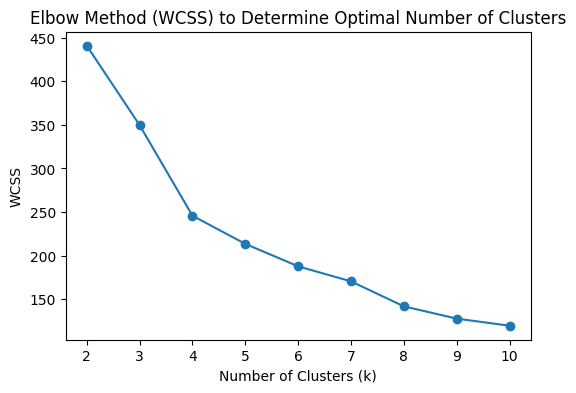

In [13]:
# Elbow method (WCSS)
wcss = []
K_values = range(2, 11)

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_values, wcss, marker='o')
plt.title("Elbow Method (WCSS) to Determine Optimal Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.show()

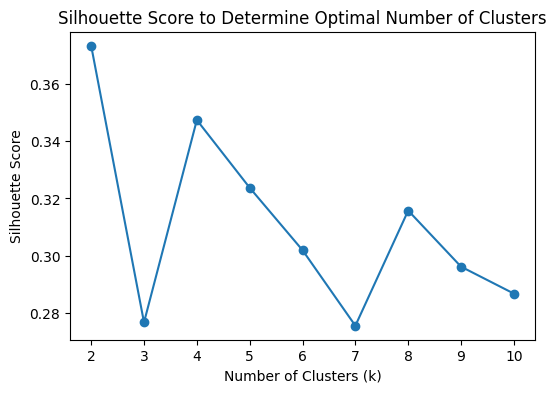

In [14]:
# Silhouette score
sil_scores = []
for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    
plt.figure(figsize=(6,4))
plt.plot(K_values, sil_scores, marker='o')
plt.title("Silhouette Score to Determine Optimal Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

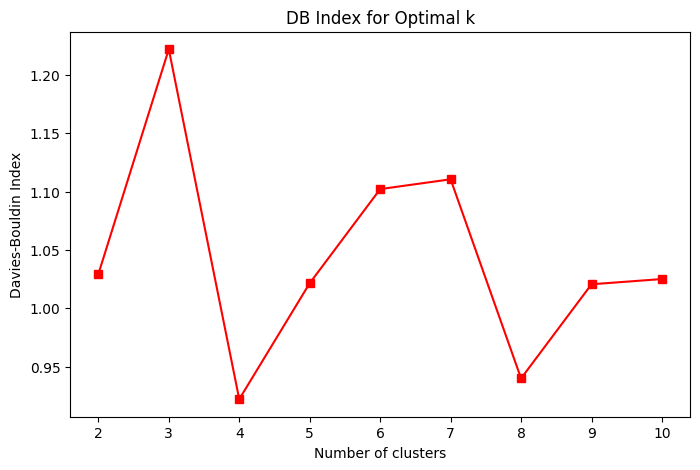

In [15]:
# Davies-Bouldin Index for each k
db_scores = []
for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    db = davies_bouldin_score(X_scaled, labels)
    db_scores.append(db)

plt.figure(figsize=(8,5))
plt.plot(K_values, db_scores, 'rs-')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('DB Index for Optimal k')
plt.show()

In [16]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)
clusters = kmeans.predict(X_scaled)

db_index = davies_bouldin_score(X_scaled, clusters)
sil_score = silhouette_score(X_scaled, clusters)
print(f"DB Index: {db_index}")
print(f"Silhouette Score: {sil_score}")

DB Index: 0.9219513061110165
Silhouette Score: 0.34741013893297057


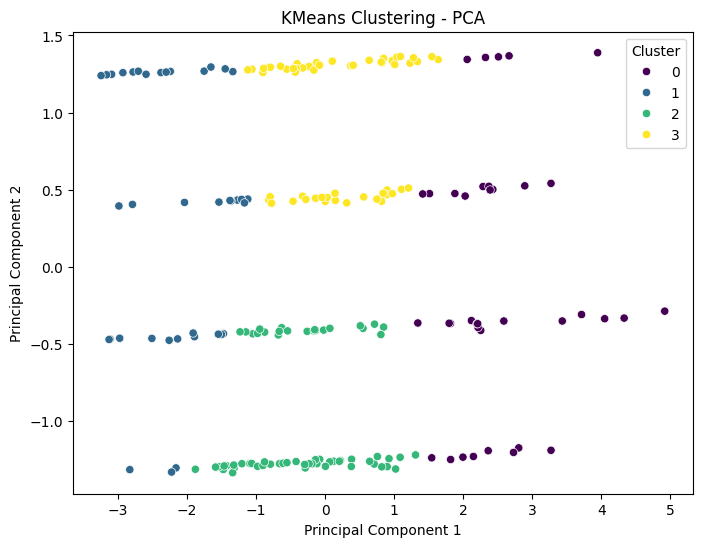

In [17]:
# Visualize clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_scaled)
clusters = kmeans.predict(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette="viridis", legend="full")
plt.title("KMeans Clustering - PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

### Approach 2

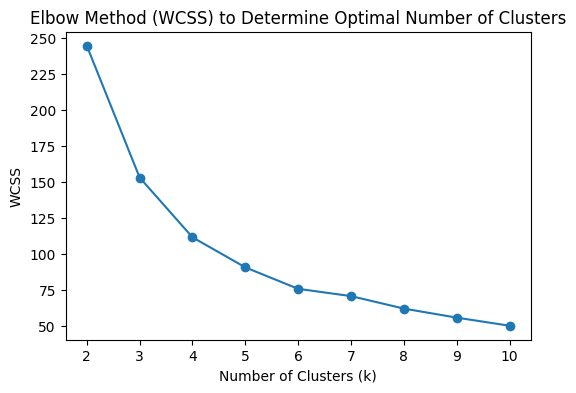

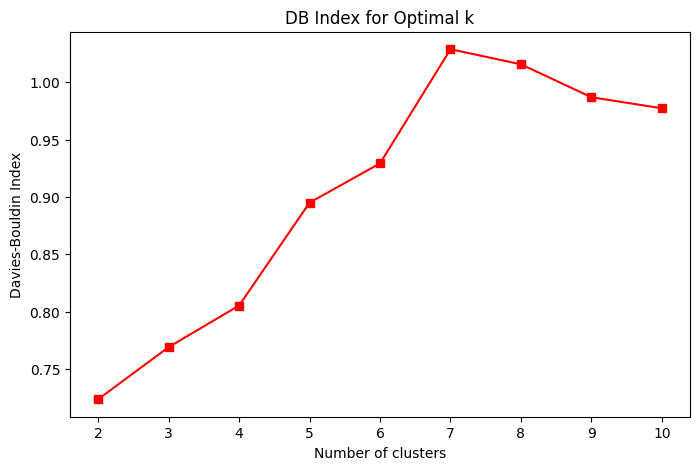

In [18]:
merged_transactions = pd.merge(transactions, products, on="ProductID", how="left")

transactions_agg = merged_transactions.groupby("CustomerID").agg({
    "Quantity": "sum",
    "TotalValue": "sum",
    "TransactionID": "count"
}).reset_index()

transactions_agg.rename(columns={
    "Quantity": "TotalQuantity",
    "TotalValue": "TotalSpend",
    "TransactionID": "NumTransactions"
}, inplace=True)

customer_data = pd.merge(customers, transactions_agg, on="CustomerID", how="left")
customer_data.fillna(0, inplace=True)
X = customer_data[["TotalSpend", "TotalQuantity", "NumTransactions"]].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# optimal number of clusters (2 to 10) using the Elbow method (WCSS)
wcss = []
K_values = range(2, 11)

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_values, wcss, marker='o')
plt.title("Elbow Method (WCSS) to Determine Optimal Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.show()

# Davies-Bouldin Index for each k
db_scores = []
for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    db = davies_bouldin_score(X_scaled, labels)
    db_scores.append(db)

# Plot Davies-Bouldin Index
plt.figure(figsize=(8,5))
plt.plot(K_values, db_scores, 'rs-')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('DB Index for Optimal k')
plt.show()

In [19]:
k_opt = [2, 3, 4]
for k in k_opt:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    clusters = kmeans.predict(X_scaled)

    db_index = davies_bouldin_score(X_scaled, clusters)
    sil_score = silhouette_score(X_scaled, clusters)
    print(f"DB Index (k={k}): {db_index}")
    print(f"Silhouette Score (k={k}): {sil_score}")

DB Index (k=2): 0.7234787545050064
Silhouette Score (k=2): 0.49373487735321214
DB Index (k=3): 0.7689520825401875
Silhouette Score (k=3): 0.4092392504726072
DB Index (k=4): 0.8052437830269734
Silhouette Score (k=4): 0.39004223332536625


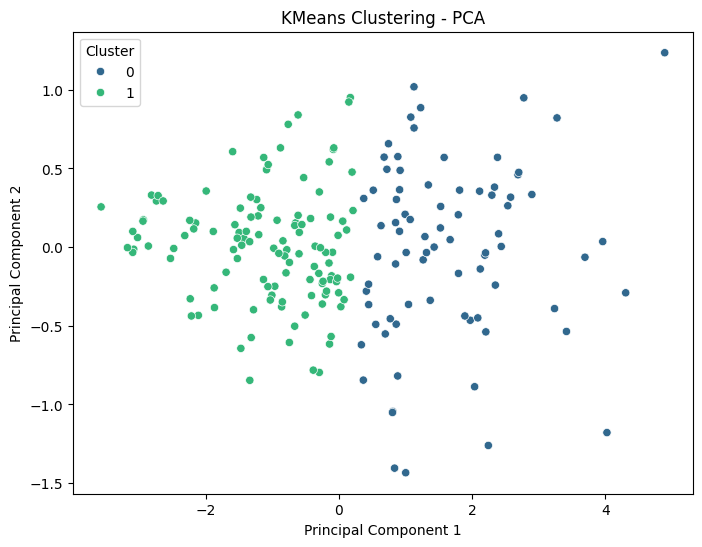

In [20]:
# Visualize clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_scaled)
clusters = kmeans.predict(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette="viridis", legend="full")
plt.title("KMeans Clustering - PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

In [21]:
# Cluster Summary
customer_data["Cluster"] = clusters
cluster_summary = customer_data.groupby("Cluster").agg({
    "TotalSpend": "mean",
    "TotalQuantity": "mean",
    "NumTransactions": "mean"
}).reset_index()

cluster_summary

,Cluster,TotalSpend,TotalQuantity,NumTransactions
0,0,5155.752532,18.721519,7.113924
1,1,2336.290165,8.743802,3.619835


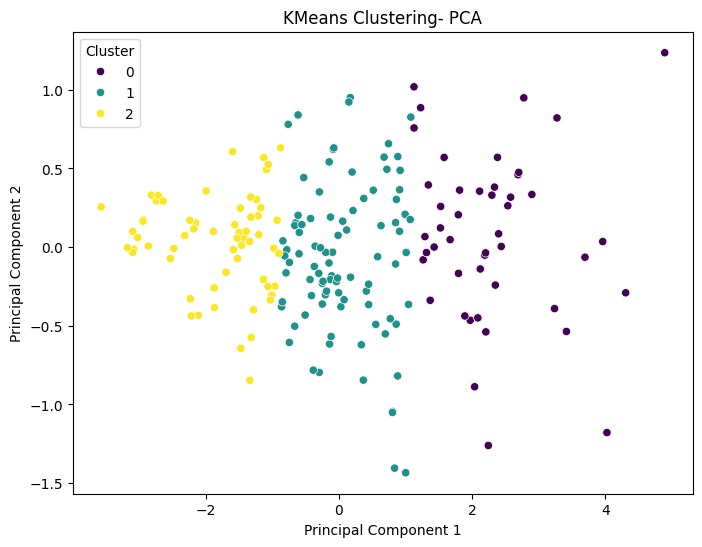

In [22]:
# Visualize clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)
clusters = kmeans.predict(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette="viridis", legend="full")
plt.title("KMeans Clustering- PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

In [23]:
# Cluster Summary
customer_data["Cluster"] = clusters
cluster_summary = customer_data.groupby("Cluster").agg({
    "TotalSpend": "mean",
    "TotalQuantity": "mean",
    "NumTransactions": "mean"
}).reset_index()

cluster_summary

,Cluster,TotalSpend,TotalQuantity,NumTransactions
0,0,5927.847826,21.260870,7.739130
1,1,3465.247717,12.771739,5.239130
2,2,1588.899516,6.193548,2.612903


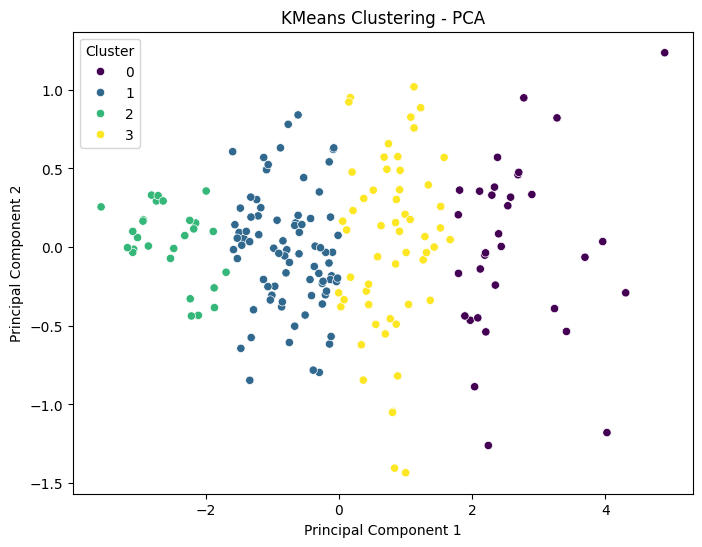

In [24]:
# Visualize clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_scaled)
clusters = kmeans.predict(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette="viridis", legend="full")
plt.title("KMeans Clustering - PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

In [25]:
# Cluster Summary
customer_data["Cluster"] = clusters
cluster_summary = customer_data.groupby("Cluster").agg({
    "TotalSpend": "mean",
    "TotalQuantity": "mean",
    "NumTransactions": "mean"
}).reset_index()

cluster_summary

,Cluster,TotalSpend,TotalQuantity,NumTransactions
0,0,6210.658485,22.545455,8.333333
1,1,2620.240361,9.975904,4.048193
2,2,816.316296,3.592593,1.703704
3,3,4307.427018,15.228070,6.017544
